<a href="https://colab.research.google.com/github/Benjamin-morel/TensorFlow/blob/main/04_%5BCV%5D_convolution_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

# **Machine Learning Model: Convolutional Neural Network**

| | |
|------|------|
| Filename | 04_[CV]_convolution_CNN.ipynb |
| Author(s) | Benjamin (contact.upside830@silomails.com) |
| Date | September 10, 2024 |
| Aim(s) | Classify images with a simple convolutional neural network |
| Dataset(s) | Flower API Google dataset [[1]](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) |
| Version | Python 3.10.12 - TensorFlow 2.17.1 - final notebook version |


<br> **!!Read before running!!** <br>
1. Fill in the inputs
2. CPU execution is enough.
3. Run all and read comments.

---

#### **Motivation**

A convolutional neural network (CNN) model is created and trained in this Python script. The objective is to classify 5 different flower classes from the Google API flower dataset.

#### **Outline**
* retrieve data & data augmentation
* CNN model
* training & evaluation
* predictions
* references

---


## **0. Input section**

The model has already been trained and the user can choose to used a pre-trained model (No) or to repeat the training phase (Yes). Using a pre-trained model saves time, computer resources and CO2 emissions.

In [1]:
training_phase = 'No'



---

## **1. Python librairies & display utilities**

In [2]:
# @title 1.1. Python librairies [RUN ME]

"""math"""
import numpy as np # linear algebra
import sklearn.metrics # scores and evaluation metrics

"""file opening and data"""
import os # miscellaneous operating system interfaces
from pandas import DataFrame # data manipulation tool

"""ML models"""
import tensorflow as tf # framework for ML/DL
from tensorflow import keras, data, expand_dims, nn, math, concat # API used to build model in TensorFlow
from keras import layers, utils, Sequential, Input, losses, callbacks

"""display"""
from PIL import Image # image processing capabilities
import matplotlib.pyplot as plt # graphing packages

"""performances"""
from time import time # timer
start = time()

In [3]:
# @title 1.2. Import Github files [RUN ME]

"""clone the Github repertory TensorFlow and import files (see section 3.3)"""
def get_github_files():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata
  path_training_curves_1 = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/results_graph.png"
  path_training_curves_2 = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/results_graph_OF.jpeg"
  path_model = 'TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/04_convolution_CNN.h5'
  training_curves_1 = Image.open(path_training_curves_1)
  training_curves_2 = Image.open(path_training_curves_2)
  model = keras.models.load_model(path_model)
  !rm -rf TensorFlow_duplicata/
  return training_curves_1, training_curves_2, model

"""clone the Github repertory TensorFlow and import photos (see section 4)"""
def get_github_photo():
  !git clone https://github.com/Benjamin-morel/TensorFlow.git TensorFlow_duplicata
  path_tulip = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/tulip.jpeg"
  path_rose = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/rose.jpeg"
  path_daisy = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/daisy.jpeg"
  path_sunflowers = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/sunflowers.jpeg"
  path_bouquet = "TensorFlow_duplicata/99_pre_trained_models/04_convolution_CNN/bouquet.jpeg"
  tulip = Image.open(path_tulip)
  rose = Image.open(path_rose)
  daisy = Image.open(path_daisy)
  sunflowers = Image.open(path_sunflowers)
  bouquet = Image.open(path_bouquet)
  !rm -rf TensorFlow_duplicata/
  return tulip, rose, daisy, sunflowers, bouquet

In [4]:
# @title 1.3. Figure plots [RUN ME]

"""plot a sample image with the label as title (see section 2.3 and section 3.1)"""
def plot_images(image, *label):
  plt.imshow(image)
  plt.title("%s" %label)
  image = plt.axis("off")
  return image

"""plot distribution of dataset labels (see section 2.3)"""
def plot_distribution(dataset, class_names):
  labels = concat([y for x, y in dataset], axis=0) # collect dataset labels only
  plt.hist(labels, bins=[0,0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4,4.5], align='mid')
  plt.xlabel("Flower name"), plt.ylabel("Total"), plt.title("Dataset label distribution"), plt.xticks([0.25, 1.25, 2.25, 3.25, 4.25], class_names)
  plt.show()

"""plot training curves (see section 3.4)"""
def plot_evolution(history):
  loss_train, loss_val = history[0], history[2]
  acc_train, acc_val = history[1], history[3]
  epochs = range(1, len(acc_train) + 1)

  plt.subplot(2,1,1, ylabel='loss')
  plt.plot(epochs, loss_train, label='Training', color='blue')
  plt.plot(epochs, loss_val, label='Validation', color='orange')
  plt.legend(loc='best', fontsize=10), plt.grid(True, linestyle='--', alpha=0.6)

  plt.subplot(2,1,2, xlabel='epoch', ylabel='accuracy')
  plt.plot(epochs, acc_train, color='blue')
  plt.plot(epochs, acc_val, color='orange')
  plt.grid(True, linestyle='--', alpha=0.6)

"""plot evaluation graphs (see section 3.4)"""
def plot_evaluation(test_dataset, predictions, labels):
  actuals = concat([y for x, y in test_dataset], axis=0)
  predicted_labels = np.argmax(predictions, axis=1)

  plt.figure(figsize=(12,5))

  confusion_mat = math.confusion_matrix(actuals,predicted_labels) # columns = prediction labels / rows = real labels
  plt.imshow(confusion_mat)

  for i in range(confusion_mat.shape[0]): # annotation in each cnfusion matrix cell
      for j in range(confusion_mat.shape[1]):
          plt.text(x=j, y=i,s=int(confusion_mat[i, j]), va='center', ha='center', size='large')
  plt.xlabel("Predictions"), plt.ylabel("Actuals"), plt.title("Confusion matrix of the test set"), plt.xticks(np.arange(len(labels)), labels), plt.yticks(np.arange(len(labels)), labels)

  # Metrics info
  accuracy = sklearn.metrics.accuracy_score(actuals, predicted_labels)
  recall = sklearn.metrics.recall_score(actuals, predicted_labels, average='weighted')
  F1_score = sklearn.metrics.f1_score(actuals, predicted_labels, average='weighted')

  print("############################")
  print("Evaluation on the test set: ")
  print("############################")
  print("Accuracy...{:.4f}" .format(accuracy))
  print("Recall.....{:.4f}" .format(recall))
  print("F1-score...{:.4f}" .format(F1_score))

  plt.show()

"""plot worst-ever model prediction (see section 3.4)"""
def plot_errors(errors_index, img_error, pred_error, test_error, class_names):
  fig, ax = plt.subplots(1, len(errors_index), figsize=(15, 30))
  for i in range(len(errors_index)):
    error = errors_index[i]
    ax[i].imshow((img_error[error])/255, cmap='gray')
    ax[i].set_title("Pred :{}\nTrue :{}".format(class_names[pred_error[error]],class_names[test_error[error]])), ax[i].set_axis_off()

---


## **2. Retrieve data and batch generation**

### 2.1. Retrieve data

The Google API flower dataset is composed of 3,670 photos of flowers labelled in 5 classes: daisy, dandelion, roses, sunflowers, tulips. The dataset is extracted and placed in the main_directory `flower_dataset` as follows: <br>

````markdown
**flower_dataset/**
. . . flower_photos/
. . . . . . daisy/
. . . . . . . . . *daisy_image1.jpg*
. . . . . . . . . *daisy_image2.jpg*
. . . . . . . . . [...]
. . . . . . dandelion/
. . . . . . . . . *dandelion_image1.jpg*
. . . . . . . . . [...]
. . . . . . [...]



In [5]:
"""retrieve data"""
def get_data(url, batch_size, height, width, validation_ratio):
  folder_name = 'flower_dataset'
  data_dir = utils.get_file(folder_name, dataset_url, untar=True)
  data_dir = os.path.join(data_dir, 'flower_photos')

  train_ds = utils.image_dataset_from_directory(data_dir, validation_split=validation_ratio, subset="training", shuffle=True, seed=1, image_size=(height, width), batch_size=batch_size, verbose=0)
  val_ds = utils.image_dataset_from_directory(data_dir, validation_split=validation_ratio, subset="validation", shuffle=True, seed=1, image_size=(height, width), batch_size=batch_size, verbose=0)
  class_names = train_ds.class_names
  return train_ds, val_ds, class_names

The original dataset is split into 3 subsets: the training (80%), validation (16%) and test (4%). The last two sets are created from a fraction of 20% of the original set.

To create subset batches, the utility `image_dataset_from_directory` is used. The test set is then created from the validation test

In [6]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

batch_size, img_height, img_width = 32, 180, 180
validation_split = 0.2 # first split used to create the final validation set and test set

train_ds, val_ds, class_names = get_data(dataset_url, batch_size, img_height, img_width, validation_split)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Using 2936 files for training.
Using 734 files for validation.


In [7]:
"""retrieve test/validation data"""
def get_test_set(dataset, portion):
  card = data.experimental.cardinality(dataset)
  dataset_test = dataset.take(card // portion)
  dataset_val = dataset.skip(card // portion)
  return dataset_test, dataset_val

In [8]:
test_ds, val_ds = get_test_set(val_ds, 5) # create a test set from 20% of the validation set

print("Set details: \nTraining set .... %d batches of %d elements each" %(data.experimental.cardinality(train_ds), batch_size),
      "\nValidation set .. %d batches of %d elements each" %(data.experimental.cardinality(val_ds), batch_size),
      "\nTest set ........ %d batches of %d elements each" %(data.experimental.cardinality(test_ds), batch_size))

Set details: 
Training set .... 92 batches of 32 elements each 
Validation set .. 19 batches of 32 elements each 
Test set ........ 4 batches of 32 elements each


### 2.2. Performance data configuration

To improve the performance of the input pipeline, the data is stored in a cache so as to avoid re-opening and re-reading it at each training step. Data batches are also opened, read and transformed successively in background with a prefetch buffer size computed by `AUTOTUNE`.

In [9]:
AUTOTUNE = data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 2.3. Data inspection

Elements of this database are very varied and rather noisy (presence of decorative elements, human, grave...).

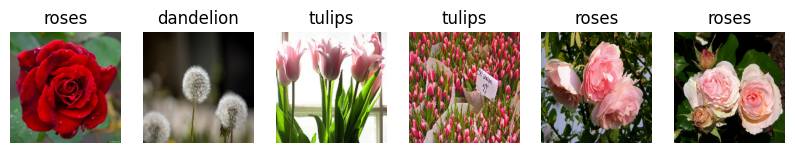

In [10]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
  tensor_images, tensor_labels = images, labels # save images/labels for 3.1
  for i in range(6):
    plt.subplot(1, 6, i + 1)
    plot_images(images[i].numpy().astype("uint8"), class_names[labels[i]])

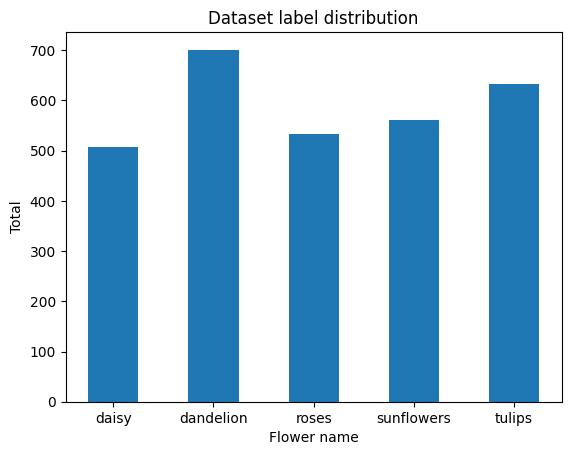

In [11]:
plot_distribution(train_ds, class_names)

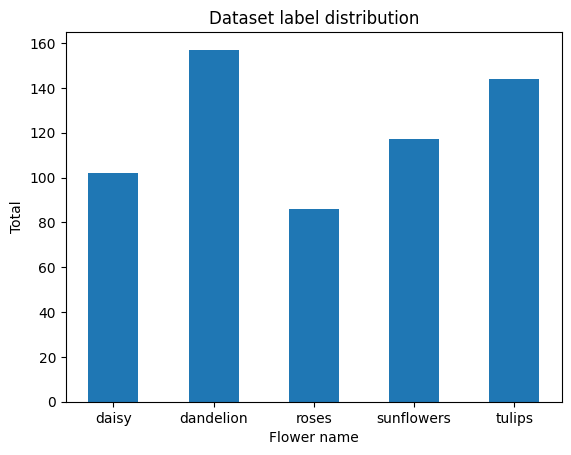

In [12]:
plot_distribution(val_ds, class_names)

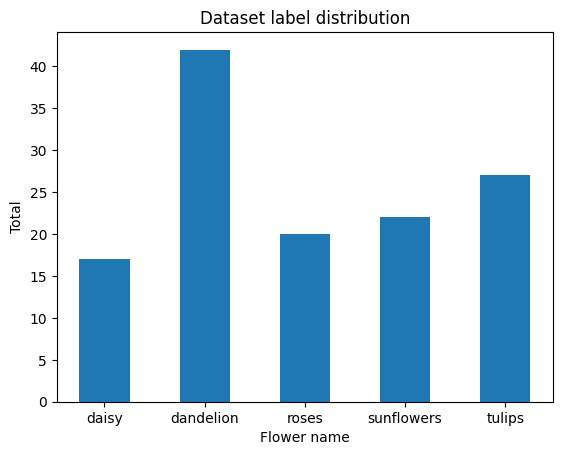

In [13]:
plot_distribution(test_ds, class_names)

The classes in the training set are unbalanced: there is a majority of dandelions (yellow flower head and papus). Data augmentation is performed to increase the number of data sets.

---


## **3. Model and training**

### 3.1. Data augmentation

The limited number of training elements given to the model doesn't lead to satisfactory performances. A risk of over-fitting is possible. The graph in section 3.4 shows a poor generalization of performance. Realistic transformations (rotation, flip & zoom) are then applied to the training data to diversify the data set.

In [14]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
outputs = layers.RandomZoom(0.1)(x)

data_augmentation = keras.Model(inputs=inputs, outputs=outputs, name="data_augmentation_layer")

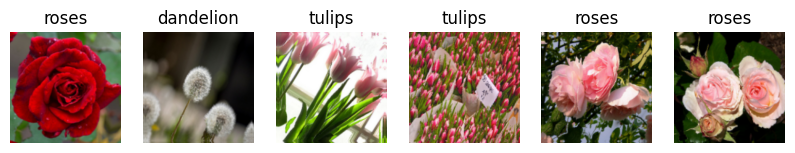

In [15]:
plt.figure(figsize=(10, 8))
images_modified = data_augmentation(tensor_images) # apply to the example set
for i in range(6):
  plt.subplot(1, 6, i + 1)
  plot_images(images_modified[i].numpy().astype("uint8"), class_names[tensor_labels[i]])

### 3.2. Model definition

The model is composed of a series of convolution/pooling layers to extract features/patterns from the input data. A classification model is then implemented to compute logit scores in output.

The neural network architecture is optimized to maximize the number of filters created by the last layer for a sufficient number of weights.  Thus, a series of 5 layers with 16 filters for the initial layer and doubled at each upper layer leads here to a total number of weights of less than 1.3 million and 1064 filters at the input of the classification model.

Here's an overview of the model's architecture at the start:

* `Input` & `Rescaling` layers:
  * **Inputs & Outputs:** a 3D tensor (`img_height`, `img_width`, `3`)

* First `Conv2D` layer:
  * **Outputs:** (`img_height`, `img_width`, `filters=16`)
  * **Comments:** `padding = 'same'` so the size of images processed is preserved

* First `MaxPooling2D` layer:
  * **Outputs:** (`img_height/2`, `img_width/2`, `filters=16`)
  * **Comments:** the maximum 2x2 value is retained

* . . .

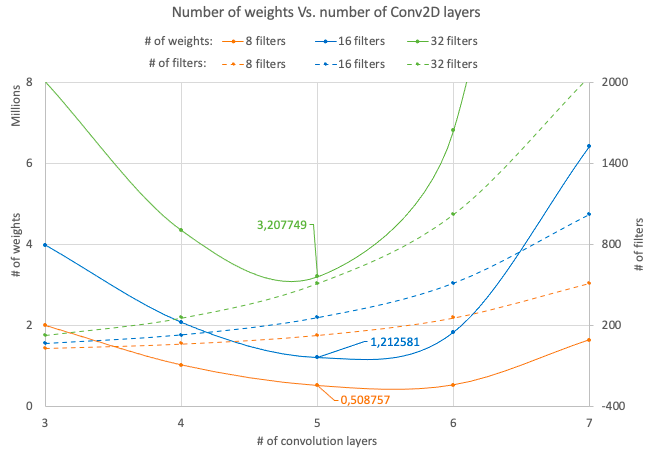

In [16]:
"""setup model"""
def create_model():
  nb_classes = len(class_names)

  inputs = keras.Input(shape=(img_height, img_width, 3))
  x = layers.Rescaling(1./255)(inputs)
  x = data_augmentation(x)
  x = layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(nb_classes)(x)
  outputs = layers.Softmax()(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name="classifier_CNN")

  model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])
  return model

### 3.3. Model training

The file is saved in .h5 format without the optimizer parameters, as the model can reach a very large number of parameters and therefore generate a large save file. The .h5 format without optimizer parameters requires the model to be recompiled once loaded.

In [17]:
"""training configuration"""
def train_model(model, training_data, validation_data, **kwargs):
  kwargs.setdefault("epochs", 5)
  kwargs.setdefault("verbose", 1)
  log = model.fit(training_data, validation_data=validation_data, validation_freq=1, callbacks=[stop_early], **kwargs)

  return log.history["loss"], log.history["sparse_categorical_accuracy"], log.history["val_loss"], log.history["val_sparse_categorical_accuracy"]

In [18]:
model = create_model()
epochs = 20

if training_phase == "Yes":
  stop_early = callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, restore_best_weights=True, min_delta=0.001)
  classifier_accuracy = train_model(model, train_ds, val_ds, epochs=epochs)
  model.save('04_convolution_CNN.h5', include_optimizer=False) # save file with .h5 format and without optimizer parameters
  print("Accuracy max %0.1f %% reached at the epoch %d" %(100*max(classifier_accuracy[3]), np.argmax(classifier_accuracy[3])+1))
else:
  training_curves, training_curves_overfitting, model = get_github_files()
  model.compile(optimizer='adam', # recompilation of the loaded model
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=[keras.metrics.SparseCategoricalAccuracy()])

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 845, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 845 (delta 195), reused 96 (delta 96), pack-reused 583 (from 2)
Receiving objects: 100% (845/845), 191.03 MiB | 28.83 MiB/s, done.
Resolving deltas: 100% (426/426), done.


### 3.4. Model evaluation and comments

A training phase without data augmentation and dropout layer was carried out beforehand and is shown on the training curve plot (right side). The use of data augmentation and layer dropout eliminated the error of over-fitting.

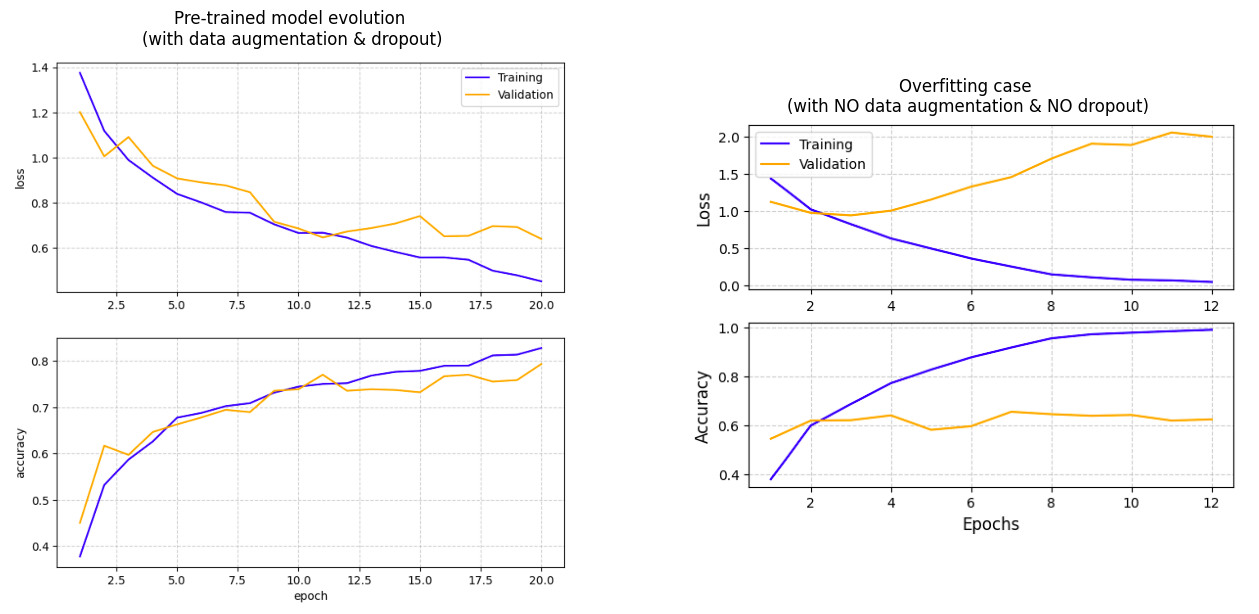

In [19]:
if training_phase == 'Yes':
  plt.figure(figsize=(8, 8))
  plot_evolution(classifier_accuracy)
else:
  plt.figure(figsize=(16, 8))
  plt.subplot(1,2,1, title="Pre-trained model evolution \n(with data augmentation & dropout)")
  plt.imshow(training_curves), plt.axis("off")
  plt.subplot(1,2,2, title="Overfitting case \n(with NO data augmentation & NO dropout)")
  plt.imshow(training_curves_overfitting), plt.axis("off")
  plt.show()

In [20]:
"""evaluate and make predictions"""
def get_predictions(dataset):
  loss_test, accuracy_test = model.evaluate(dataset, verbose=0)
  predictions = model.predict(dataset, verbose=0)
  print("Test loss value: %0.1f \nTest accuracy: %0.1f %%" %(loss_test, 100*accuracy_test))
  return predictions

In [21]:
predictions = get_predictions(test_ds)

Test loss value: 0.8 
Test accuracy: 75.8 %


############################
Evaluation on the test set: 
############################
Accuracy...0.7578
Recall.....0.7578
F1-score...0.7524


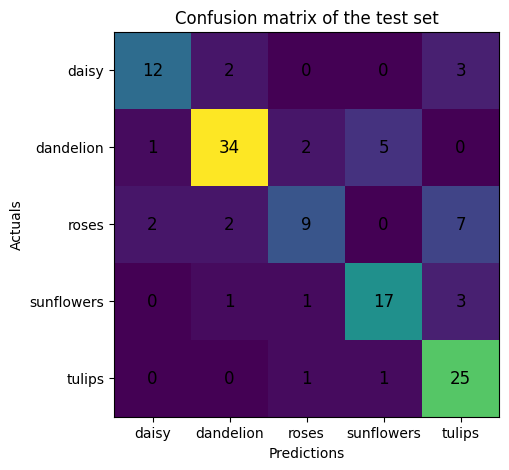

In [22]:
plot_evaluation(test_ds, predictions, class_names)

In [23]:
"""return worst-case model errors"""
def get_worst_top(probabilities, y_test, x_test, rate):
  y_test_predicted = np.argmax(probabilities, axis=1)
  errors = (y_test_predicted - y_test != 0) # collects indexes of incorrect predictions
  y_predicted_error = y_test_predicted[errors] # mispredicted labels
  error_number = len(y_predicted_error)
  y_test_error = y_test[errors] # true labels

  y_predicted_error_probabilities = probabilities[errors]
  x_test_error = x_test[errors] # get images of mispredicted labels

  y_predicted_error_probability = np.max(y_predicted_error_probabilities, axis = 1) # get probabilities that led to errors
  y_test_error_probability = np.diagonal(np.take(y_predicted_error_probabilities, y_test_error, axis=1)) # get probabilities of a true values in the error set

  delta_errors = y_predicted_error_probability - y_test_error_probability
  delta_errors = np.argsort(delta_errors)
  top_errors = delta_errors[-int(rate*error_number):]
  print("%0.0f/%0.0f images belong to the top %0.0f-errors" %(len(top_errors), error_number, len(top_errors)))

  return top_errors, x_test_error, y_predicted_error, y_test_error

9/31 images belong to the top 9-errors


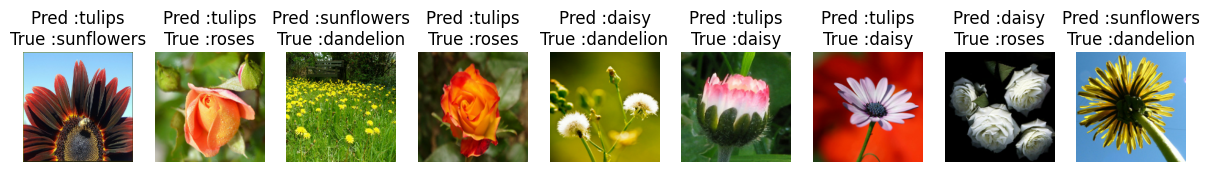

In [24]:
error_rate = 0.3

x_test = concat([x for x, y in test_ds], axis=0)
y_test = concat([y for x, y in test_ds], axis=0)

top_errors, x_test_error, y_predicted_error, y_test_error = get_worst_top(predictions, y_test, x_test, error_rate)
plot_errors(top_errors, x_test_error, y_predicted_error, y_test_error, class_names)

3/4 of images are correctly classified. Significant confusion remains between roses Vs. tulips and dandelions Vs. sunflowers. These confusions could be explained by color confusions and background pollution.

---


## **4. Predictions**

The model can be used to make predictions for flower photos found on Google Image. The softmax function is used to transform the logit scores output by the model into probabilities. 4 out of 5 are correctly recognized. The model is also tested on bouquet photos comprising 2 types of flowers.

In [25]:
tulip, rose, daisy, sunflowers, bouquet = get_github_photo()

Cloning into 'TensorFlow_duplicata'...
remote: Enumerating objects: 845, done.
remote: Counting objects: 100% (262/262), done.
remote: Compressing objects: 100% (166/166), done.
remote: Total 845 (delta 195), reused 96 (delta 96), pack-reused 583 (from 2)
Receiving objects: 100% (845/845), 191.03 MiB | 19.72 MiB/s, done.
Resolving deltas: 100% (426/426), done.


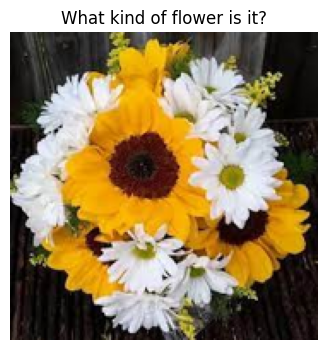

In [26]:
img = bouquet
img = Image.fromarray(np.array(img))
resized_img = img.resize((img_height, img_width))
plt.figure(figsize=(4, 4))
plt.imshow(resized_img), plt.title("What kind of flower is it?"), plt.axis("off")
plt.show()

In [27]:
resized_img_array = expand_dims(np.array(resized_img), 0)
score = model.predict(resized_img_array)

df = DataFrame(data={'class_names': class_names, 'score': 100*score[0]})
print(df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
  class_names      score
0       daisy  42.316479
1   dandelion   0.134146
2       roses   0.000981
3  sunflowers  57.545654
4      tulips   0.002739


---


## **5. Conclusions and limitations**

The accuracy of the test set - 80% - and the failure to identify 2 flower types on the same photo, the complexity of the task demands a more robust model, extracting more complex and numerous features.

A possible solution to increase the accuracy of the test set would be to make the feature/pattern extraction model more complex. As the images are noisy due to many external elements (graves, vases, humans, etc.), it is necessary to isolate these features. In the Python Script [05_transfert_learning.ipynb](https://github.com/Benjamin-morel/TensorFlow), the same task is performed, but with a much more complex feature/pattern extraction model.

---


## **6. References**


| | | | | |
|------|------|------|------|------|
| Index | Title | Author(s) | Type | Comments |
|[[1]](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition) | Flowers Recognition | Alexander Mamaev | dataset | - |
|[[2]](https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks) | Convolutional Neural Networks cheatsheet | Afshine Amidi and Shervine Amidi | lecture | - |
|[[3]](https://www.tensorflow.org/tutorials/images/cnn) | Convolutional Neural Network (CNN) | TensorFlow | Tutoriels | - |
|[[4]](https://www.tensorflow.org/tutorials/images/data_augmentation) | Data augmentation | TensorFlow | Tutoriels | - |
|[[5]](https://cs231n.github.io/) | Convolutional Neural Networks for Visual Recognition | Stanford cs231n | lecture | - |

In [28]:
print("Notebook run in %.1f seconds on %s" % ((time() - start), tf.config.list_physical_devices(device_type=None)[-1][-1]))

Notebook run in 56.6 seconds on GPU
